In [ ]:
## 环境准备
!pip install umap-learn numpy pandas scikit-learn seaborn matplotlib xgboost  -i https://pypi.tuna.tsinghua.edu.cn/simple

In [9]:
## 加载依赖
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import xgboost as xgb

import re
import os
import sys

current_dir = os.getcwd()
sys.path.append(os.path.dirname(current_dir))
from utils.jxh import preprocess_raw_for_modeling

In [10]:
## 读取数据 & 预处理
dating = pd.read_csv('../data/speeddating.csv')
dating = preprocess_raw_for_modeling(dating)

/home/newdisk/jxh/课程项目/数据挖掘/Data-Mining-pj/utils/jxh.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dating['met'].replace(number,0, inplace =True)    # 见过次数--转化为是否见过01变量


,gender,race,race_o,samerace,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,...,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_matches,like,guess_prob_liked,met,match,age_diff
0,female,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,35.0,20.0,20.0,20.0,...,8.0,1.0,0.14,3.0,4.0,7.0,6.0,0.0,0,-6.0
1,female,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,60.0,0.0,0.0,40.0,...,8.0,1.0,0.54,3.0,4.0,7.0,5.0,1.0,0,-1.0
2,female,Asian/Pacific Islander/Asian-American,Asian/Pacific Islander/Asian-American,1,2.0,4.0,19.0,18.0,19.0,18.0,...,8.0,1.0,0.16,3.0,4.0,7.0,NaN,1.0,1,-1.0
3,female,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,30.0,5.0,15.0,40.0,...,8.0,1.0,0.61,3.0,4.0,7.0,6.0,0.0,1,-2.0
4,female,Asian/Pacific Islander/Asian-American,Latino/Hispanic American,0,2.0,4.0,30.0,10.0,20.0,10.0,...,8.0,1.0,0.21,3.0,4.0,6.0,6.0,0.0,1,-3.0


In [12]:
# Selecting numeric columns
columns_numeric = dating.select_dtypes(include = ['int','float']).columns.tolist()

# Selecting categorical columns
columns_category = dating.select_dtypes(include = ['object']).drop('match', axis=1).columns

In [19]:
X = dating.drop('match', axis = 1)
y = dating['match'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 33 )

# Define the pipeline for numeric features
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define the pipeline for categorical features
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values = '?', fill_value = 'Unknown', strategy = 'constant')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine numeric and categorical transformers
preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, columns_numeric),
    ('categorical', categorical_pipeline, columns_category)
])


# Apply preprocessing to train and test sets
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


numeric_column_names = columns_numeric
categorical_column_names = preprocessor.named_transformers_['categorical']['encoder'].get_feature_names_out(columns_category)

# Combine numeric and categorical column names
all_column_names = numeric_column_names + categorical_column_names.tolist()

# Convert preprocessed data to DataFrame
X_train = pd.DataFrame(X_train_preprocessed, columns=all_column_names)
X_test = pd.DataFrame(X_test_preprocessed, columns=all_column_names)

print('Training set shape is', X_train.shape, 'and test set shape is', X_test.shape)

Training set shape is (6283, 70) and test set shape is (2095, 70)


In [20]:
X_train

,samerace,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,...,race_European/Caucasian-American,race_Latino/Hispanic American,race_Other,race_Unknown,race_o_Asian/Pacific Islander/Asian-American,race_o_Black/African American,race_o_European/Caucasian-American,race_o_Latino/Hispanic American,race_o_Other,race_o_Unknown
0,-0.810499,0.433029,0.842389,2.192581,0.376708,-1.519531,-2.063382,-0.105988,-1.074483,-1.152857,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.810499,-0.990314,0.842389,-0.990929,0.376708,-0.046383,-0.409144,1.539494,0.500752,-0.105888,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.233807,-0.990314,-0.953340,2.192581,0.376708,-1.519531,-1.236263,-0.928729,-1.074483,-0.629373,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.810499,1.856371,-0.953340,-0.460079,-0.101547,-0.536941,-0.132886,0.685489,1.055234,1.988050,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.233807,-0.990314,-0.953340,-0.460079,-0.101547,-0.536941,-0.132886,0.991548,0.763816,-0.105888,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6278,-0.810499,-0.990314,-0.953340,0.865853,-0.900075,-1.356012,-1.052643,0.076661,1.638071,-0.105888,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6279,-0.810499,-0.990314,-0.953340,2.192581,-1.059493,-0.046383,-1.236263,-0.105988,-1.862100,-1.676342,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6280,-0.810499,1.856371,0.842389,-0.195051,0.376708,-0.046383,0.417975,1.539494,-1.862100,0.417596,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6281,-0.810499,1.500535,-0.235048,-0.435407,-0.328467,-0.491273,-0.081605,1.353554,0.514929,-2.199827,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [21]:
## 实例化不同的模型以测试其准确性
logreg = LogisticRegression(max_iter=10000)
svc = SVC()
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
xg_cl = xgb.XGBClassifier()

classifiers = [('logreg', logreg), ('svc', svc), ('knn', knn), ('random forest', rf), ('xgboost', xg_cl)]

# 拟合不同的模型并计算准确性
for clf_name, model in classifiers:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = (np.sum(y_pred == y_test)) / (len(y_pred))
    print(clf_name, accuracy)

logreg 0.8620525059665871
svc 0.8725536992840095
knn 0.8400954653937948
random forest 0.8687350835322196
xgboost 0.8668257756563246


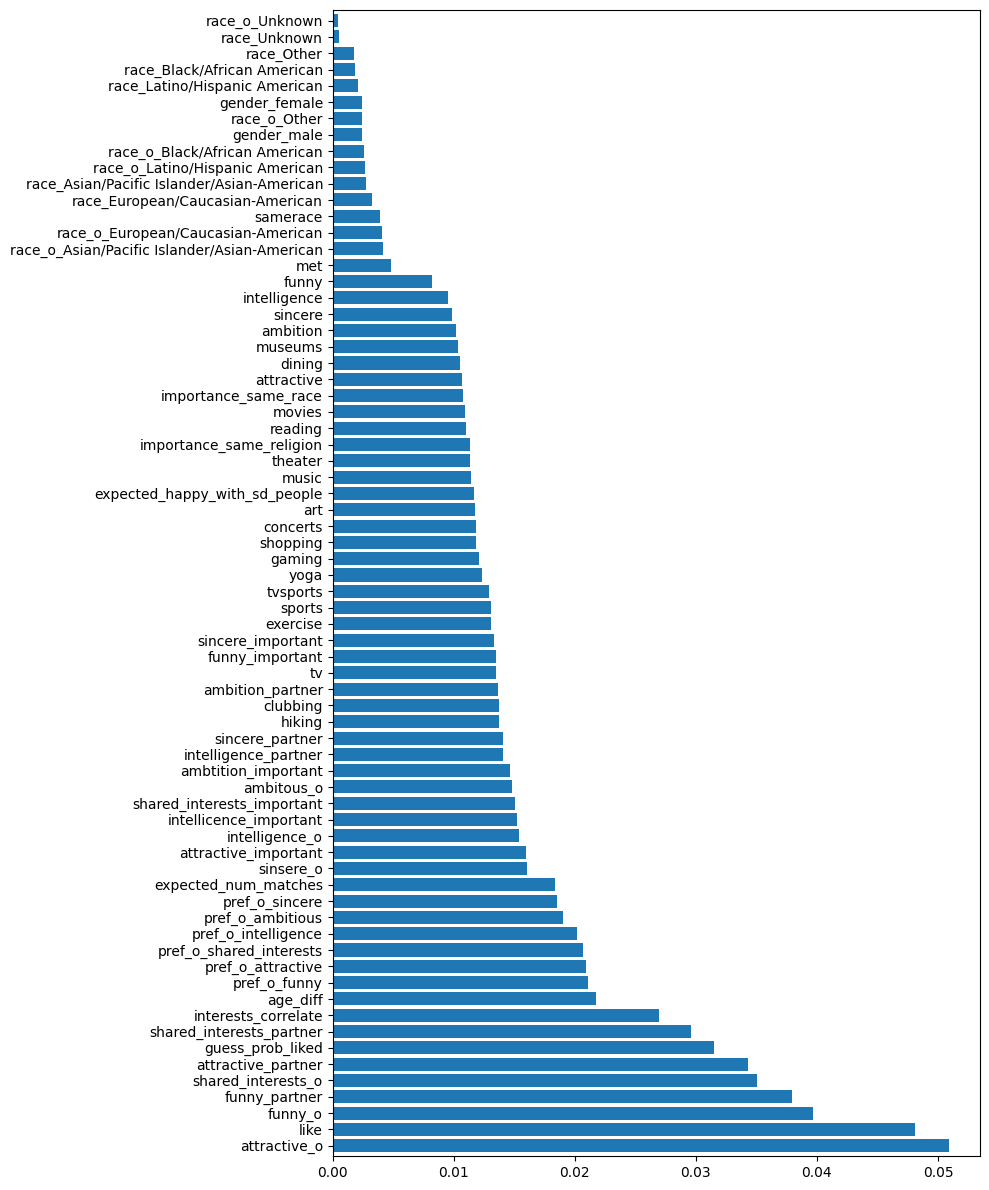

In [29]:
## 特征选择 （随机森林）

# Retrieve the feature importances
rf_importance = pd.Series(rf.feature_importances_, index = rf.feature_names_in_)
rf_importance = rf_importance.sort_values(ascending = False)

# 可视化
fig = plt.figure(figsize = (10,12))
rf_importance.plot(kind = 'barh', width =0.8)
plt.tight_layout()
plt.show()

In [24]:
# 特征过滤 + xgboost
top_features = rf_importance[rf_importance>0.01].index

xg_cl = xgb.XGBClassifier()

# Fit the model
xg_cl.fit(X_train[top_features], y_train)

# Make predictions
y_pred = xg_cl.predict(X_test[top_features])
accuracy = (np.sum(y_pred == y_test))/(len(y_pred))
print(f'Dropping features from {len(rf_importance)} to {len(top_features)} give an accuracy of {accuracy}')

Dropping features from 70 to 52 give an accuracy of 0.871599045346062


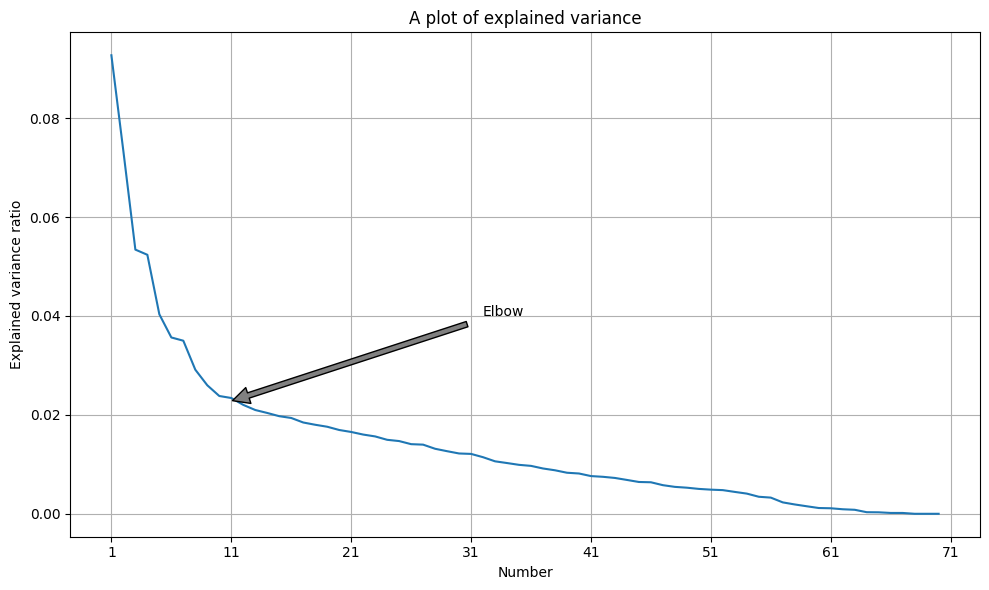

In [25]:
## PCA 维度缩减
pca = PCA()
pca.fit(X_train, y_train)
variance = pca.explained_variance_ratio_

fig = plt.figure(figsize = (10,6))
sns.lineplot(variance)
plt.grid(True)
plt.xlabel('Number')
plt.ylabel('Explained variance ratio')
plt.title('A plot of explained variance')
plt.xticks(np.arange(0,80,10), np.arange(1,81,10))
plt.annotate('Elbow',xy =[9, 0.022], xytext = [31, 0.04], arrowprops=dict(facecolor='grey', shrink=0.05))
plt.tight_layout()
plt.show()

In [26]:
## PCA + xgboost

pca = PCA(n_components = 11)

xgb_cl = xgb.XGBClassifier()

# Fit and transform the training set
X_train_transformed = pca.fit_transform(X_train)

# Transform the test set
X_test_tranformed = pca.transform(X_test)

# Fit and predict with the transformed datasets
xgb_cl.fit(X_train_transformed,y_train)
y_pred = xgb_cl.predict(X_test_tranformed)
accuracy = (np.sum(y_pred == y_test))/(len(y_pred))
print(accuracy)

0.8486873508353222
